# Stereo Matching with Pytorch

## **Part 2: Learning based stereo matching**

Rather than of using SSD/SAD to compute a matching cost for the disparity map, in this part we will train a network to directly learn that from the data instead. You'll be implementing what has been proposed in the paper [[Zbontar & LeCun, 2015]](https://arxiv.org/abs/1409.4326) and see how it performs compare to classical cost matching approaches.

**Note:**
As a reminder, this notebook is intendend to be run on [Google Colab](https://colab.research.google.com). So first upload to Google Drive, and then change the runtime to use GPU by select "Runtime" -> "Change runtime time" -> "Hardward accelerator". Select "GPU" and click "Save".


##Submission:
Similar to part 1, this part requires a report to be submitted on gradescope along with a zip archive to be submitted on canvas containing the filled in jupyter notebook and .pth file for your best model. 

Fill in the relevant details in `proj5b_template.pptx` and export it as a pdf to generate the report. This has to be submitted on gradescope.

##Rubric:
This project is worth 50 points, the points for each section is specified in `proj5b_template.pptx`.


## Setup 

For this part, we will be using Google Colab, which is a cloud based jupyter notebook environment. You can choose to run this part locally as well, especially if you have a good GPU, but the assignment is designed to run on Colab with GPU. You’ll first need to upload proj5.2_6320/mc-cnn.ipynb to Google Colab first, then you’ll be able to run them the same way you run any other notebook.

In Colab, make sure you select GPU in the menu “Runtime” -> “Change runtime time” -> “Hardward accelerator”

### Loading dataset and supported files

Here we will download neccessary data and set up the environment. You can skip this if the data files is still in your colab environment

Run the cell below only for the first run or if you want to redownload the support files

In [1]:
#download and extract the data -- training data

#Run the section below only for initial setup
!gdown https://drive.google.com/u/3/uc?id=1DrTR72TafPE2KIOyrWv4doKoc2W6_JqC #Archive containing the dataset
!unzip KITTI2015_Stereo.zip
!rm KITTI2015_Stereo.zip

!gdown https://drive.google.com/u/3/uc?id=138_VfDCHPqHctDOyIYcrUjbv_p7mnMb5 #Util functions
!gdown https://drive.google.com/u/3/uc?id=1GqlD502mQsqerMTnga8aGJ62TcMGt94I #cnn_disparity_map
!gdown https://drive.google.com/u/3/uc?id=1RAd4Dn7vcPLrIYPWMaqAh5aoHFm_2qMa #sgm

# Download and pretrainings for the appropriate window size
!gdown https://drive.google.com/u/3/uc?id=1MjWOVFMonrgXGdLAP04rgzyMSv_CdiQ- #w5
!gdown https://drive.google.com/u/3/uc?id=18bPMw_2ymzOvoiqUwCNZWDGfmZ5rUcvG #w9
!gdown https://drive.google.com/u/3/uc?id=1wfWsYx91RnDNFOT-OLdSHku_DfqNzO2l #w11
!gdown https://drive.google.com/u/3/uc?id=1FtKl3whSfTDfRQvgzNrLAhpH8dIheUS6 #w17


Downloading...
From (uriginal): https://drive.google.com/u/3/uc?id=1DrTR72TafPE2KIOyrWv4doKoc2W6_JqC
From (redirected): https://drive.google.com/uc?id=1DrTR72TafPE2KIOyrWv4doKoc2W6_JqC&confirm=t&uuid=2b7b59bf-0962-47b6-92d7-417463b0c7e4
To: /home/sci/janmesh/Documents/classwork/CS-6320/proj_5b_6320/KITTI2015_Stereo.zip
100%|████████████████████████████████████████| 671M/671M [00:16<00:00, 41.2MB/s]
Archive:  KITTI2015_Stereo.zip
   creating: KITTI2015_Stereo/disp_noc_0/
  inflating: KITTI2015_Stereo/disp_noc_0/000000_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000001_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000002_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000003_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000004_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000005_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000006_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000007_10.png  
  inflating: KITTI2015_Stereo/disp_noc_0/000008_10.png  
  inflating:

In [1]:
#import torch and set tensor type
import torch
%matplotlib inline
import matplotlib.pyplot as plt

use_cuda = True and torch.cuda.is_available()
if use_cuda:
  print("Running with GPU acceleration")
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

torch.backends.cudnn.deterministic = True
torch.manual_seed(333) #do not change this, this is to ensure your result is reproduciable

Running with GPU acceleration


## DataLoader

In [2]:
#this is loading up all the data to train
from custom_utils import DataLoader
import numpy as np
import os

data_dir = 'KITTI2015_Stereo/'

nnz = DataLoader(data_dir, verbose=False) #Might take a few secs to execute. (Set verbose=True to print out files being loaded)

X, dispnoc = nnz


Loaded 200 data points from KITTI2015_Stereo/


Left Image


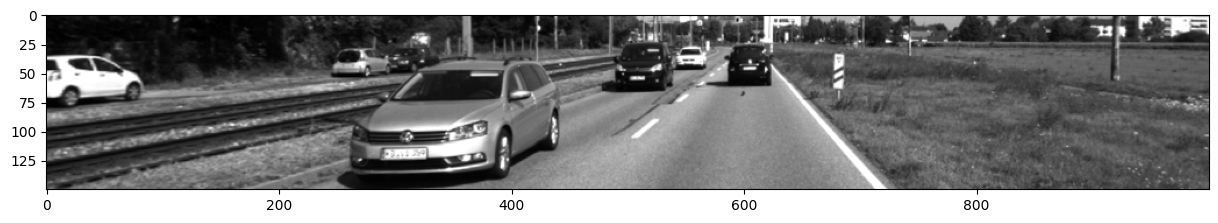

Right Image


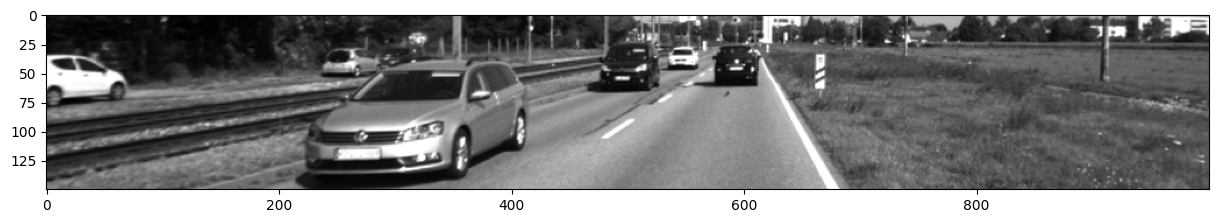

Ground Truth disparity


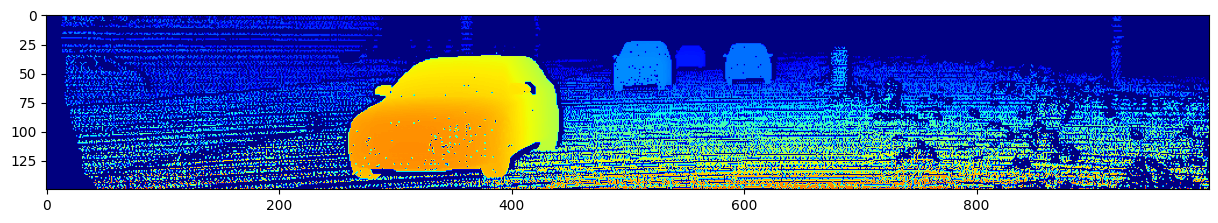

In [3]:
#visualize the data
#pick image for testing
ind_img = 4
print('Left Image')
plt.figure(figsize = (15,5))
plt.imshow(X[ind_img][0][0][0][0].cpu().numpy(),cmap="gray")
plt.show()
print('Right Image')
plt.figure(figsize = (15,5))
plt.imshow(X[ind_img][0][0][1][0].cpu().numpy(),cmap="gray")
plt.show()
print('Ground Truth disparity')
plt.figure(figsize = (15,5))
plt.imshow(dispnoc[ind_img].cpu().numpy(), cmap='jet')
plt.show()

# Network Architecture

In this part, **you** will be implementing **MCNET** network architecture as described in the paper.

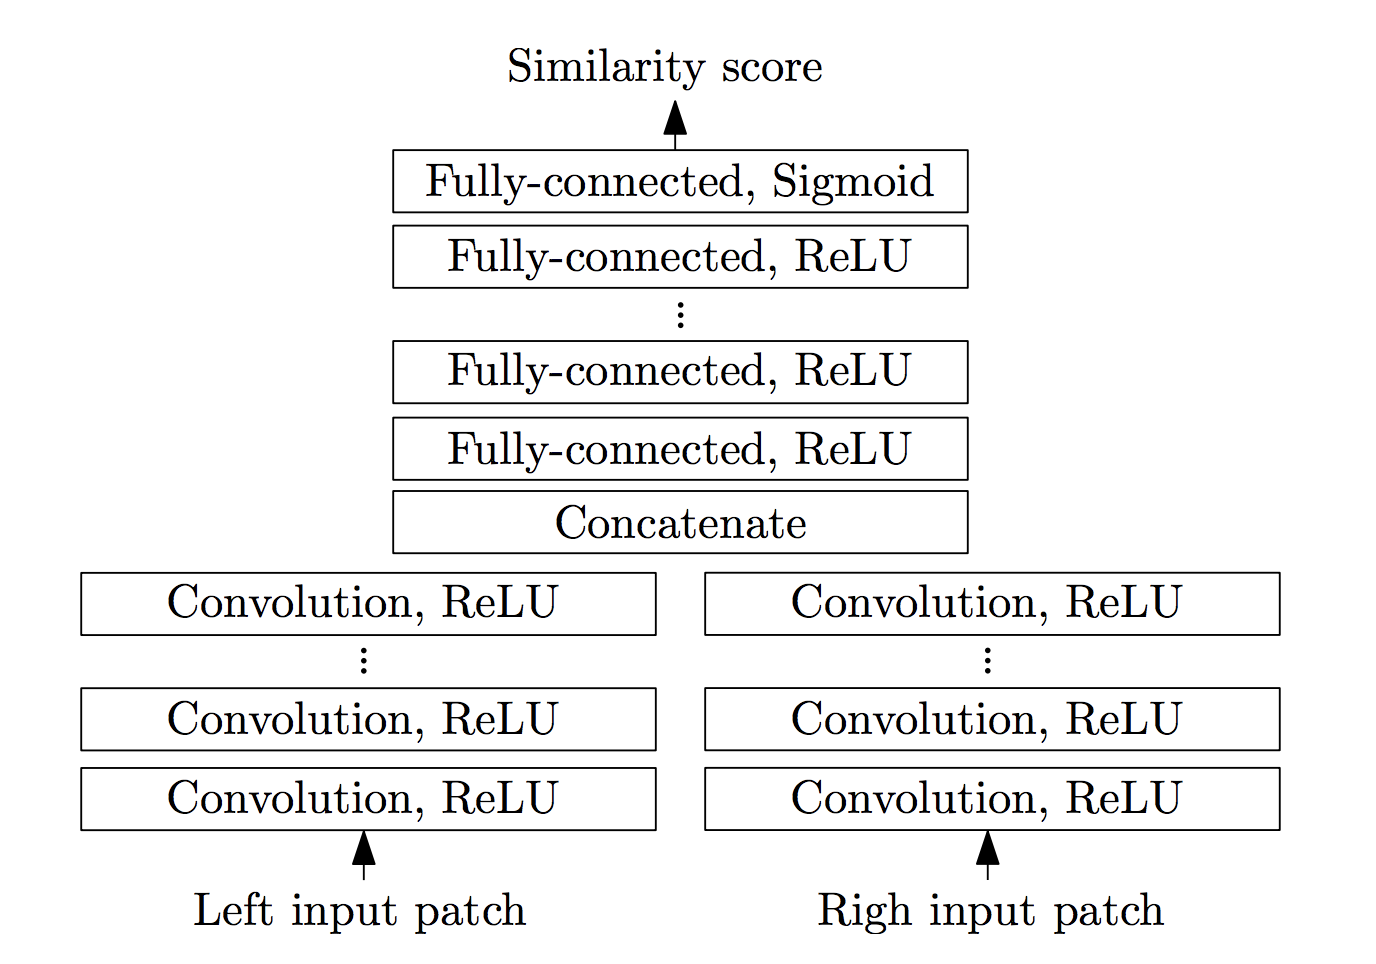

The inputs to the network are 2 image patches, coming from left and right images, each will pass through a series of convolution + ReLU layers. The extracted features are then concatenated and passed through another fully connected + ReLU layers. The output is a single real number between 0 and 1, indicating the similarity between the two input images [Zbontar & LeCun, 2015]

In this case, since training from scratch will take a really long time to converge, you’ll be training from our pre-trained network instead. In order to load up the pre-trained network, you must first implement the architecture exactly as described here.

|Hyperparameter||
|---|---|	 
|input_patch_size|11x11|
|num_conv_layers|5|
|num_conv_feature_maps|112|
|conv_kernel_size|3|
|num_fc_layers|3|
|num_fc_units|384|

For efficiency we will convolve both input images in the same batch (this means that the input to the network will be 2xbatch_size). After the convolutional layers, we will then reshape them into (batch_size, conv_out) where conv_out is the output size of the convolutional layers. This will then be passed through a series of fully connected layers and finally a Sigmoid layer to bound the output value to 0/1.

Here is the example of such network with num_conv_layers = 1 and num_fc_layers = 2:

    nn.Sequential(
            nn.Conv2d(in_channel, num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),

            Reshape((batch_size,conv_out)), #this is a custom layer provided in the notebook which will reshape the input into the specified size

            nn.Linear(conv_out,num_hidden_unit),
            nn.ReLU(),
            nn.Linear(num_hidden_unit,1),
            nn.Sigmoid(),
            )

In [4]:
from torch import nn
from custom_utils import save_model, load_model

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)
      
      
class MCNET(torch.nn.Module):
    """

    MCNET based on paper from [Zbontar & LeCun, 2015]. This network takes as input two patches of size 11x11 and output the 
    likelihood of the two patches being a match. 

    Args:
    -   ws: window size (or blocking size) of the input patch
    -   batch_size: batch size 
    Returns:
    -   matching cost between the 2 patches, we use 0 for positive match (represent 0 cost to match) and 1 for negative match

    """

    def __init__(self, ws = 11, batch_size=512, load_path = None, strict=True):
        super(MCNET, self).__init__()
        
        num_feature_map = 112 
        kernel_size = 3
        num_hidden_unit = 384
        self.batch_size = batch_size
        self.ws = ws
        self.strict = strict

        self.net = nn.Sequential(
            ############################################################################
            # Student code begin
            ############################################################################
            nn.Conv2d(in_channels=1, out_channels=num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_feature_map, out_channels=num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_feature_map, out_channels=num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_feature_map, out_channels=num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_feature_map, out_channels=num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),

            Reshape((batch_size, num_feature_map*2*(ws**2))),

            nn.Linear(num_feature_map*2*(ws**2), num_hidden_unit),
            nn.ReLU(),
            nn.Linear(num_hidden_unit,num_hidden_unit),
            nn.ReLU(),
            nn.Linear(num_hidden_unit,1),
            nn.Sigmoid(),
            ############################################################################
            # Student code end
            ############################################################################

        ).to(device)

        self.criterion = nn.BCELoss().to(device)
        if load_path is not None:
          self.net = load_model(self.net,load_path)

    def forward(self, x):
        
        return self.net(x)

Load pretrained model below to ensure the implemented architecture matches the pretrained architecture

In [5]:
######################################################################
#Preload the provided pretrained model, you can also load your
#saved models here.

#You can also train from scratch by setting load_path to None
#######################################################################

net_tr = MCNET(ws=11,load_path = 'mc_cnn_pretrain_w11.pth')

print(net_tr)

MCNET(
  (net): Sequential(
    (0): Conv2d(1, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Reshape()
    (11): Linear(in_features=27104, out_features=384, bias=True)
    (12): ReLU()
    (13): Linear(in_features=384, out_features=384, bias=True)
    (14): ReLU()
    (15): Linear(in_features=384, out_features=1, bias=True)
    (16): Sigmoid()
  )
  (criterion): BCELoss()
)


**Deliverables:** Network architecture implementation in MCNET and copy the output of `print(net_tr)` above to the report.


**Questions**: 
1.   What's the purpose of ReLU and why do we add it after every conv and fc layers?



# Data preparation

In [6]:
def gen_patch(image, x, y, ws = 11):
    """
    function to return a patch of size ws at a specific location of the image.
    x, y in this case is a top left corner of the patch, for example if x,y is (0,0)
    you should return a patch over (0,0) and (ws,ws)
    
    For corner case, you can pad the output with zeros such that we always have 
    (channel, ws, ws) dimension output
    
    Args:
    -   image: image of type Tensor with dimension (channel, width, height)
    -   x: x location in the image 
    -   y: y location in the image
    -   ws: window size or block size of the patch we want
    Returns:
    -   patch: a patch of size (channel, ws, ws) of type Tensor

    """
    ############################################################################
    # Student code begin
    ############################################################################
    c, w, h = image.shape
    region = image[:,int(x):int(x)+ws,int(y):int(y)+ws]
    patch =  torch.zeros((c, ws, ws))
    patch[:,:region.shape[1], :region.shape[2]] = region
    return patch
    ############################################################################
    # Student code end
    ############################################################################

The following code samples patches with positive matches and negative matches from the dataset using the gen_patch() function defined above.

Ensure that `patch from image A` and `positive patch from image B` looks moslty similar on multiple runs. Otherwise check your implementation for gen_patch().

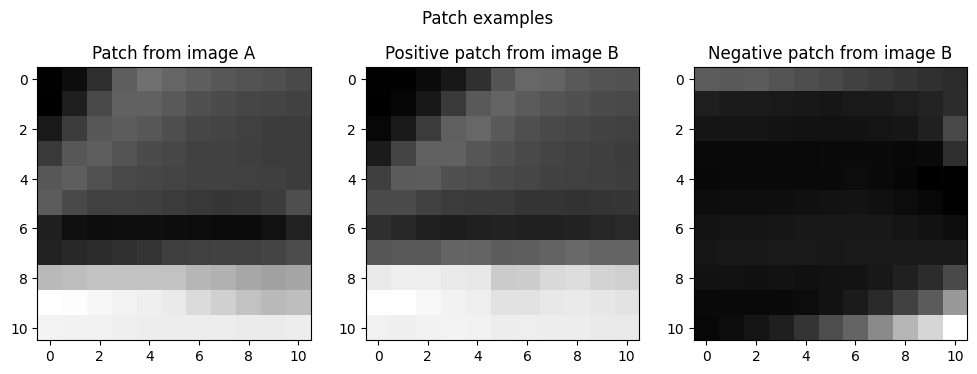

In [7]:
import math
from custom_utils import get_disparity

ind = np.random.randint(0,len(nnz))

img, dim3, dim4, d = get_disparity(nnz,ind)

d_pos = 0
d_neg = torch.Tensor(1).uniform_(5,25)

if torch.Tensor(1) < 0.5:
    d_neg = -d_neg

x0 = X[int(img)][0][0,0]
x1 = X[int(img)][0][0,1]

anchor = gen_patch(x0, dim3, dim4)
pos = gen_patch(x1, dim3, dim4 - d + d_pos)
neg = gen_patch(x1, dim3, dim4 - d + d_neg)

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(anchor[0].cpu().numpy(),cmap='gray')
plt.title('Patch from image A')

plt.subplot(1, 3, 2)
plt.imshow(pos[0].cpu().numpy(),cmap='gray')
plt.title('Positive patch from image B')

plt.subplot(1, 3, 3)
plt.imshow(neg[0].cpu().numpy(),cmap='gray')
plt.title('Negative patch from image B')

fig.suptitle('Patch examples')
plt.show()


**Deliverables:** Implement gen_patch() function and copy the patch example above to the report

**Questions:** 
1.   Giving a true disparity map for each stereo pair, how do we extract positive and negative patches for the training?



# Train

In the following part, the goal is to train a network that learn how to classify 2 patches as positive vs negative match. Your task is to train a best network by experimenting with the learning parameters below. There is no coding required in this part, but you should familiarize yourself with how the training and tuning parameters work.

In [13]:
def run_net(model, nnz, batch_size, ws=11,  max_epoch=1, split='train', optimizer=None, viz_frequency=1, save_frequency=200, fname="mc_cnn_network.pth"):
    epoch = 1
    loss_history = []
    datalen = int(nnz[1].shape[0])
    num_samples = int(2e3)
    try:
        for epoch in range(max_epoch):
            for t in range(1, int(num_samples - batch_size // 2), batch_size // 2):
                x_batch_tr = torch.zeros(batch_size*2, 1, ws, ws).type(tensor_type).to(device)
                y_batch_tr = torch.zeros(batch_size).type(tensor_type).to(device)
                x_batch_tr_ = torch.zeros(x_batch_tr.size()).to(device)
                y_batch_tr_ = torch.zeros(y_batch_tr.size()).to(device)
                for i in range(1,batch_size//2 + 1):
                    d_pos = 0
                    d_neg = torch.Tensor(1).uniform_(1.5,18)

                    if torch.rand(1) < 0.5:
                        d_neg = -d_neg
			  
                    if split=='train':
                        ind = torch.randint(10, datalen, (1,))[0]
                    elif split=='test':
                        ind = torch.randint(0, 10, (1,))[0]
                    img, dim3, dim4, d = get_disparity(nnz,ind)

                    if len(X[int(img)]) == 0:
                        continue

                    x0 = X[int(img)][0][0,0]
                    x1 = X[int(img)][0][0,1]

                    #normalize image
                    x0 = x0.add(-x0.mean()).div(x0.std())
                    x1 = x1.add(-x1.mean()).div(x1.std())

                    x_batch_tr_[i * 4 - 4] = gen_patch(x0, dim3, dim4, ws=ws)
                    x_batch_tr_[i * 4 - 3] = gen_patch(x1, dim3, dim4 - d + d_pos, ws=ws)
                    x_batch_tr_[i * 4 - 2] = gen_patch(x0,  dim3, dim4, ws=ws)
                    x_batch_tr_[i * 4 - 1] = gen_patch(x1, dim3, dim4 - d + d_neg, ws=ws)

                    y_batch_tr_[i*2-2] = 0
                    y_batch_tr_[i*2-1] = 1

                x_batch_tr = (x_batch_tr_).clone()
                y_batch_tr = (y_batch_tr_).clone()

                output = model(x_batch_tr)
                loss = model.criterion(output,y_batch_tr.view(batch_size,1))
                if split == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                loss_history.append(loss.data.cpu().numpy())
                
            if ((epoch) % viz_frequency) == 0:
                print(f'Iteration: {epoch}, Loss: {loss.data}')
				
            if epoch == 1 or ((epoch) % save_frequency) == 0:
                save_model(model.net,fname)
    except KeyboardInterrupt:
        save_model(model.net,"bk_"+fname)
    return loss_history

You are all set to train your model. Try experimenting with the various parameters in the cell below to train different models. Evaluate your models using the evaluate_model() function provided in the subsequent cells. Try to Train a model which has a validation_loss less then 0.3

Pretrained weights are provided for windows sizes 5,9,11,17. Set variable `load_pth = 'mc_cnn_pretrain_w<ws>.pth'` to load them. For other window sizes, the model has to be trained from scratch.

During training the model is saved as `save_pth` every save_frequency iterations. Use this variable to save multiple models, **remember to download your saved models before closing the notebook and they get deleted on the notebook is closed**. You can access them from the files tab on the left. You can also set load_pth as you saved .pth file to continue training on your saved model.

P.S.: If the training is stopped by a keyboard interrupt, the latest trained model is saved as bk_+save_pth

Iteration: 0, Loss: 0.6366174817085266
Iteration: 5, Loss: 0.465082049369812
Iteration: 10, Loss: 0.41559410095214844
Iteration: 15, Loss: 0.4125135838985443
Iteration: 20, Loss: 0.39048081636428833
Iteration: 25, Loss: 0.4242464303970337
Iteration: 30, Loss: 0.35291150212287903
Iteration: 35, Loss: 0.41473186016082764
Iteration: 40, Loss: 0.3825429081916809
Iteration: 45, Loss: 0.3548256456851959
Iteration: 50, Loss: 0.34801527857780457
Iteration: 55, Loss: 0.3657589256763458
Iteration: 60, Loss: 0.3518736958503723
Iteration: 65, Loss: 0.3852277398109436
Iteration: 70, Loss: 0.3320866823196411
Iteration: 75, Loss: 0.3745731711387634
Iteration: 80, Loss: 0.34187695384025574
Iteration: 85, Loss: 0.3398602604866028
Iteration: 90, Loss: 0.3158687353134155
Iteration: 95, Loss: 0.40600505471229553
Iteration: 100, Loss: 0.366669237613678
Iteration: 105, Loss: 0.3868207335472107
Iteration: 110, Loss: 0.38973623514175415
Iteration: 115, Loss: 0.3552297353744507
Iteration: 120, Loss: 0.31202805

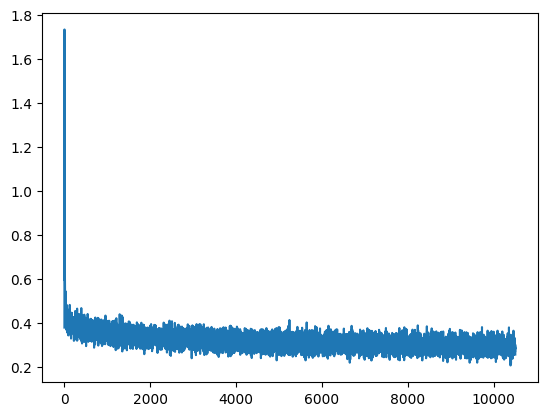

In [14]:
#train
import math
import time
st = time.time()

viz_frequency = 5
save_frequency = 50 #for saving model

############# EXPERIMENT WITH THESE ########

save_pth = 'mc_cnn_trained_w11.pth' #The filename to save your model, feel free to change the name
load_pth = 'mc_cnn_pretrain_w11.pth' #The filename to load previously trained model

#you can change this to load up pretrain network for other window size
#net_tr = MCNET(ws=11, batch_size = 512, load_path = None) #Use this model to train from scratch
net_tr = MCNET(ws=11, batch_size = 512, load_path = load_pth) 

max_epoch = 1501
learning_rate = 6e-4 # Try values 2,1,0.1,0.01,1e-5

#Swap out optimizers to identify which works best for your model.
optimizer = torch.optim.Adam(net_tr.net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#optimizer = torch.optim.SGD(net_tr.net.parameters(), lr=learning_rate, momentum=0.9)
############################################

batch_size = net_tr.batch_size
ws = net_tr.ws

loss_history = run_net(model=net_tr,
                       nnz=nnz, 
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch, 
                       split='train', 
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname = save_pth
                      )

print('Time elasped: ', time.time() - st) 

print('Training Loss')
plt.plot(loss_history)
plt.show()

In [8]:
def evaluate_network(network):

  #compute loss on the held out validation set 
  num_test_epochs = 50
  
  batch_size = network.batch_size
  ws = network.ws

  loss_history = run_net(model=network,
                         nnz=nnz, 
                         batch_size=batch_size, 
                         ws=ws, 
                         max_epoch=num_test_epochs, 
                         split='test', 
                         viz_frequency=num_test_epochs+1, 
                         save_frequency=save_frequency)
  
   #validation_loss))
  return np.mean(np.array(loss_history))

In [19]:
load_pth = 'mc_cnn_trained_w11.pth'
net_te = MCNET(ws=11, load_path = load_pth) #The model to be validated
val_loss = evaluate_network(net_te)

print('Final average validation loss:', val_loss)

Iteration: 0, Loss: 0.2692181468009949
Final average validation loss: 0.29687318


**Deliverables:** train the network to achieve the lowest error as possible. Copy the training loss plot and the final validation loss to the report.

**Questions:** 


1.   How does changing learning rate (try using large (> 1) vs small value (< 1e-5)) effect the training? Why do you think that's the case?
2.   What's the difference between Adam and SGD? What do you notice when switching between them?
3.   Is your validation loss lower or higher than your training loss? What is the reason for that? How would we get a better validation loss?




## Vary window size

In the previous section, we use window size of 11 as suggested in the paper, meaning that the input to the network will be patches of size 11x11. This corresponds to the block size that will be used when perform stereo matching later on.

In this part we would like you to experiment with other window size, namely 5x5, 9x9, and 15x15 and compare the performance. You can set this in the previous cell for training, Feel free to make copies of previous cells to achieve this.

Iteration: 0, Loss: 0.6778039932250977
Iteration: 5, Loss: 0.605121374130249
Iteration: 10, Loss: 0.5472254753112793
Iteration: 15, Loss: 0.5177943110466003
Iteration: 20, Loss: 0.5308130979537964
Iteration: 25, Loss: 0.5297330617904663
Iteration: 30, Loss: 0.5234633088111877
Iteration: 35, Loss: 0.4964175820350647
Iteration: 40, Loss: 0.5097121596336365
Iteration: 45, Loss: 0.5012327432632446
Iteration: 50, Loss: 0.4821566641330719
Iteration: 55, Loss: 0.5066694617271423
Iteration: 60, Loss: 0.4741869568824768
Iteration: 65, Loss: 0.4995083808898926
Iteration: 70, Loss: 0.6610790491104126
Iteration: 75, Loss: 0.4653196930885315
Iteration: 80, Loss: 0.4674375057220459
Iteration: 85, Loss: 0.45930808782577515
Iteration: 90, Loss: 0.48789912462234497
Iteration: 95, Loss: 0.46016234159469604
Iteration: 100, Loss: 0.42112255096435547
Iteration: 105, Loss: 0.45345550775527954
Iteration: 110, Loss: 0.4251067042350769
Iteration: 115, Loss: 0.4513537883758545
Iteration: 120, Loss: 0.4292540252

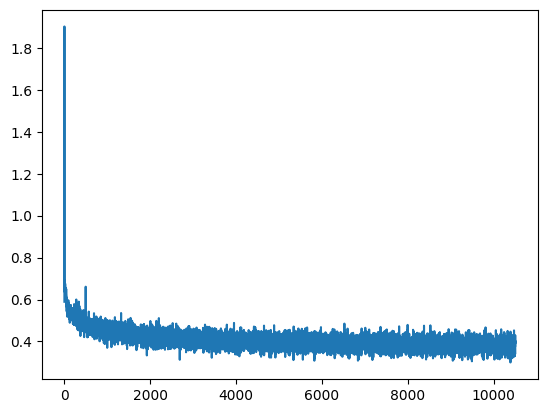

In [24]:
#train
import math
import time
st = time.time()

viz_frequency = 5
save_frequency = 50 #for saving model

############# EXPERIMENT WITH THESE ########

save_pth = 'mc_cnn_trained_w5.pth' #The filename to save your model, feel free to change the name
load_pth = 'mc_cnn_pretrain_w5.pth' #The filename to load previously trained model

#you can change this to load up pretrain network for other window size
#net_tr = MCNET(ws=11, batch_size = 512, load_path = None) #Use this model to train from scratch
net_tr = MCNET(ws=5, batch_size = 512, load_path = load_pth) 

max_epoch = 1501
learning_rate = 6e-4 # Try values 2,1,0.1,0.01,1e-5

#Swap out optimizers to identify which works best for your model.
optimizer = torch.optim.Adam(net_tr.net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#optimizer = torch.optim.SGD(net_tr.net.parameters(), lr=learning_rate, momentum=0.9)
############################################

batch_size = net_tr.batch_size
ws = net_tr.ws

loss_history = run_net(model=net_tr,
                       nnz=nnz, 
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch, 
                       split='train', 
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname = save_pth
                      )

print('Time elasped: ', time.time() - st) 

print('Training Loss')
plt.plot(loss_history)
plt.show()

In [25]:
load_pth = 'mc_cnn_trained_w5.pth'
net_te = MCNET(ws=5, load_path = load_pth) #The model to be validated
val_loss = evaluate_network(net_te)

print('Final average validation loss:', val_loss)

Iteration: 0, Loss: 0.3786621391773224
Final average validation loss: 0.38316262


Iteration: 0, Loss: 0.5125473737716675
Iteration: 5, Loss: 0.4312780499458313
Iteration: 10, Loss: 0.44218361377716064
Iteration: 15, Loss: 0.4201280474662781
Iteration: 20, Loss: 0.40656134486198425
Iteration: 25, Loss: 0.4206239879131317
Iteration: 30, Loss: 0.39012786746025085
Iteration: 35, Loss: 0.40346020460128784
Iteration: 40, Loss: 0.3767891526222229
Iteration: 45, Loss: 0.3974692225456238
Iteration: 50, Loss: 0.3872123062610626
Iteration: 55, Loss: 0.36635780334472656
Iteration: 60, Loss: 0.37799444794654846
Iteration: 65, Loss: 0.36178046464920044
Iteration: 70, Loss: 0.41072070598602295
Iteration: 75, Loss: 0.38424766063690186
Iteration: 80, Loss: 0.40267103910446167
Iteration: 85, Loss: 0.365481972694397
Iteration: 90, Loss: 0.36114007234573364
Iteration: 95, Loss: 0.36779773235321045
Iteration: 100, Loss: 0.3826664984226227
Iteration: 105, Loss: 0.37908270955085754
Iteration: 110, Loss: 0.37298521399497986
Iteration: 115, Loss: 0.36284375190734863
Iteration: 120, Loss: 0.

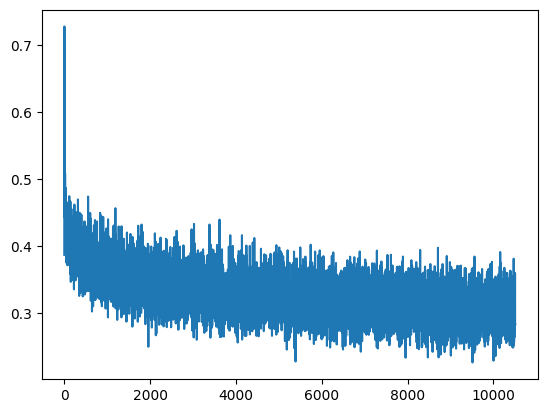

In [26]:
#train
import math
import time
st = time.time()

viz_frequency = 5
save_frequency = 50 #for saving model

############# EXPERIMENT WITH THESE ########

save_pth = 'mc_cnn_trained_w9.pth' #The filename to save your model, feel free to change the name
load_pth = 'mc_cnn_pretrain_w9.pth' #The filename to load previously trained model

#you can change this to load up pretrain network for other window size
#net_tr = MCNET(ws=11, batch_size = 512, load_path = None) #Use this model to train from scratch
net_tr = MCNET(ws=9, batch_size = 512, load_path = load_pth) 

max_epoch = 1501
learning_rate = 6e-4 # Try values 2,1,0.1,0.01,1e-5

#Swap out optimizers to identify which works best for your model.
optimizer = torch.optim.Adam(net_tr.net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#optimizer = torch.optim.SGD(net_tr.net.parameters(), lr=learning_rate, momentum=0.9)
############################################

batch_size = net_tr.batch_size
ws = net_tr.ws

loss_history = run_net(model=net_tr,
                       nnz=nnz, 
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch, 
                       split='train', 
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname = save_pth
                      )

print('Time elasped: ', time.time() - st) 

print('Training Loss')
plt.plot(loss_history)
plt.show()

In [27]:
load_pth = 'mc_cnn_trained_w9.pth'
net_te = MCNET(ws=9, load_path = load_pth) #The model to be validated
val_loss = evaluate_network(net_te)

print('Final average validation loss:', val_loss)

Iteration: 0, Loss: 0.27941638231277466
Final average validation loss: 0.30352274


Iteration: 0, Loss: 0.6885678768157959
Iteration: 5, Loss: 0.663705587387085
Iteration: 10, Loss: 0.6357415318489075
Iteration: 15, Loss: 0.4950714707374573
Iteration: 20, Loss: 0.4997808635234833
Iteration: 25, Loss: 0.4357125461101532
Iteration: 30, Loss: 0.43453025817871094
Iteration: 35, Loss: 0.40014928579330444
Iteration: 40, Loss: 0.41524550318717957
Iteration: 45, Loss: 0.3705078959465027
Iteration: 50, Loss: 0.4040728211402893
Iteration: 55, Loss: 0.3821418583393097
Iteration: 60, Loss: 0.4048531949520111
Iteration: 65, Loss: 0.3762376010417938
Iteration: 70, Loss: 0.4014585018157959
Iteration: 75, Loss: 0.37708550691604614
Iteration: 80, Loss: 0.369697630405426
Iteration: 85, Loss: 0.3731606602668762
Iteration: 90, Loss: 0.38636982440948486
Iteration: 95, Loss: 0.39539092779159546
Iteration: 100, Loss: 0.3488711416721344
Iteration: 105, Loss: 0.32997095584869385
Iteration: 110, Loss: 0.3991570472717285
Iteration: 115, Loss: 0.3722498416900635
Iteration: 120, Loss: 0.440896511

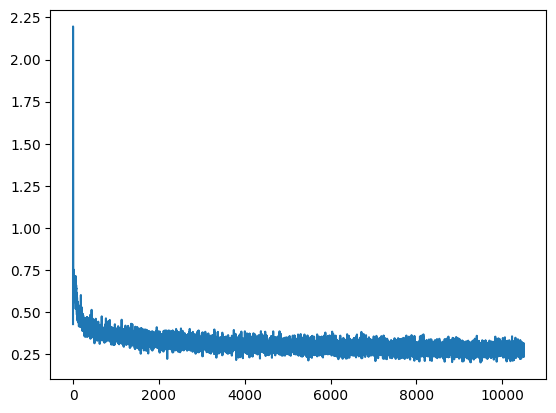

In [28]:
#train
import math
import time
st = time.time()

viz_frequency = 5
save_frequency = 50 #for saving model

############# EXPERIMENT WITH THESE ########

save_pth = 'mc_cnn_trained_w17.pth' #The filename to save your model, feel free to change the name
load_pth = 'mc_cnn_pretrain_w17.pth' #The filename to load previously trained model

#you can change this to load up pretrain network for other window size
#net_tr = MCNET(ws=11, batch_size = 512, load_path = None) #Use this model to train from scratch
net_tr = MCNET(ws=17, batch_size = 512, load_path = load_pth) 

max_epoch = 1501
learning_rate = 6e-4 # Try values 2,1,0.1,0.01,1e-5

#Swap out optimizers to identify which works best for your model.
optimizer = torch.optim.Adam(net_tr.net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#optimizer = torch.optim.SGD(net_tr.net.parameters(), lr=learning_rate, momentum=0.9)
############################################

batch_size = net_tr.batch_size
ws = net_tr.ws

loss_history = run_net(model=net_tr,
                       nnz=nnz, 
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch, 
                       split='train', 
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname = save_pth
                      )

print('Time elasped: ', time.time() - st) 

print('Training Loss')
plt.plot(loss_history)
plt.show()

In [30]:
load_pth = 'mc_cnn_trained_w17.pth'
net_te = MCNET(ws=17, load_path = load_pth) #The model to be validated
val_loss = evaluate_network(net_te)

print('Final average validation loss:', val_loss)

Iteration: 0, Loss: 0.2817176878452301
Final average validation loss: 0.2805108


**Deliverables:** Training loss curves and validation loss for window sizes of 5, 9, 15 added to the report.


**Questions**: 
1.   What's the effect of varying the window size on performance? Do you suppose there is an optimal window size for all images? Explain why or why not. 


# Evaluate stereo matching

For this part we will again generate the disparity map but this time from our newly trained matching cost network instead of SAD/SSD. You should first **upload 2 files from part 1 (similarity_measures.py, disparity_map.py)** into colab environment. Click at the `>` sign on the top left, choose `Files` tab, then upload the 2 files into the current directory.

Note that all the required functions in part 1 need to be implemented correctly before starting this part. Use this part to evaluate your trained network as a stereo matching cost.  

Hint: You don't have to re-train the network every time you want to evaluate, as long as your saved model is in Colab file system. Don't forget to change `load_path` to your best model,

In [9]:
###########Change to your best model here################

best_model = 'mc_cnn_trained_w11.pth' #Change this to your best model file
net_te = MCNET(batch_size = 30, load_path = best_model) 

############################################

In [10]:
try:
  from similarity_measures import sad_similarity_measure,ssd_similarity_measure
  from disparity_map import calculate_disparity_map
except ModuleNotFoundError:
  print('\033[91m Error: please upload disparity_map.py and similarity_measures.py from part 1\033[0m ')
from custom_utils import DataLoader
import numpy as np
import os
import time

ind_img = 162
scale = 1
im_left = X[ind_img][0][0][0][0][::scale,::scale]
im_right = X[ind_img][0][0][1][0][::scale,::scale]
im_dispnoc = dispnoc[ind_img][::scale,::scale]
im_dispnoc_full = dispnoc[ind_img]

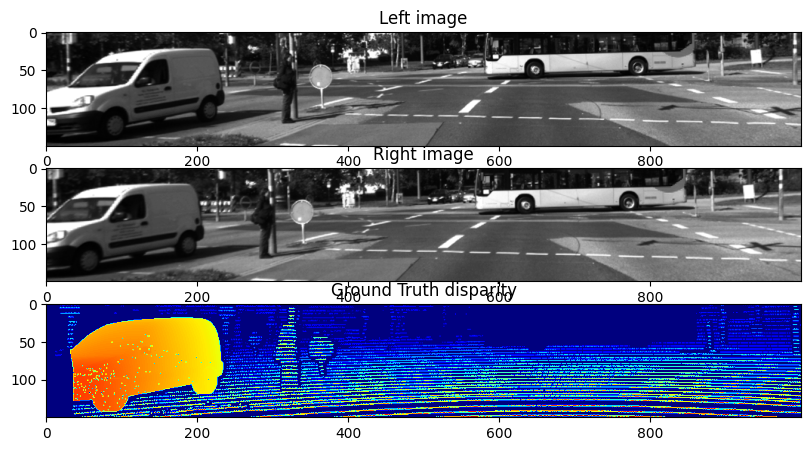

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(5*3)

ax1.imshow(im_left.cpu().numpy(), cmap="gray")
ax1.title.set_text('Left image')

ax2.imshow(im_right.cpu().numpy(), cmap="gray")
ax2.title.set_text('Right image')

ax3.imshow(im_dispnoc.cpu().numpy(), cmap="jet")
ax3.title.set_text('Ground Truth disparity')

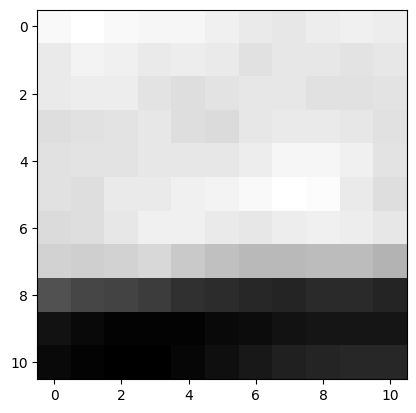

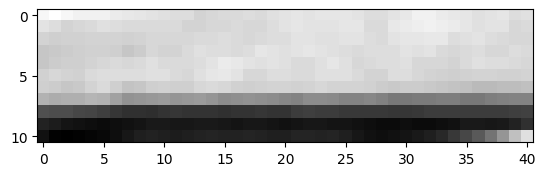

In [12]:
# extract a patch of interest from the left image
patch_left_img = im_left[95:106, 265:276]

# get the search area in the right image
search_area_right_img = (im_right[95:106, 240:281])

plt.imshow(patch_left_img.cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(search_area_right_img.cpu().numpy(),cmap='gray')
plt.show()


In [13]:
def cnn_batch_similarity_measure(patch1, strip, ws=11, max_search_bound=30):
    """

    """
    assert patch1.shape[0]==strip.shape[0]
    assert patch1.shape[1]==ws
    assert strip.shape[1]>=ws

    x = torch.zeros([max_search_bound*2, 1, ws, ws])
    max_range = min(max_search_bound, strip.shape[1]-ws+1)
    if isinstance(patch1,np.ndarray):
      patch1 = torch.tensor(patch1)
      patch1 = patch1.add(-patch1.mean()).div(patch1.std()).reshape(1,ws,ws)
    for i in range(max_range):
      x[i*2] = patch1
      patch2 = torch.tensor(strip[:,strip.shape[1]-ws-i:strip.shape[1]-i])
      patch2 = patch2.add(-patch2.mean()).div(patch2.std()).reshape(1,1,ws,ws)
      x[i*2 + 1] = patch2

    output = net_te(x.to(device))
    return output[:max_range].detach().cpu().numpy()

SSD Took:  0.0011353492736816406
SAD Took:  0.0009663105010986328


/tmp/ipykernel_12310/1706089864.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch2 = torch.tensor(strip[:,strip.shape[1]-ws-i:strip.shape[1]-i])


CNN Took:  1.0627455711364746


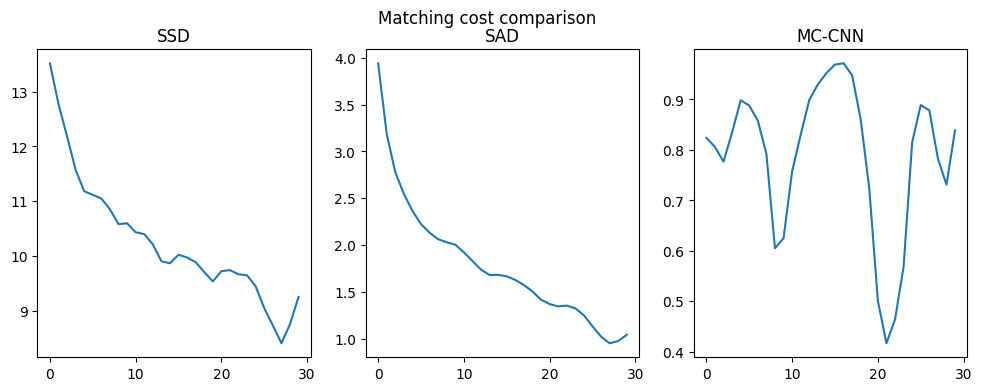

In [14]:
import time

fig = plt.figure(figsize=(12,4))

st = time.time()
similarity_vals = np.array([sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-11)])
print('SSD Took: ', time.time()-st)
plt.subplot(1, 3, 1)
plt.plot(similarity_vals[::-1])
plt.title('SSD')

st = time.time()
similarity_vals = np.array([ssd_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-11)])
print('SAD Took: ', time.time()-st)
plt.subplot(1, 3, 2)
plt.plot(similarity_vals[::-1])
plt.title('SAD')

max_search_bound = 30
net_te = MCNET(batch_size = max_search_bound, load_path = 'mc_cnn_pretrain_w11.pth') 
st = time.time()
similarity_vals = cnn_batch_similarity_measure(patch_left_img, search_area_right_img)
print('CNN Took: ', time.time()-st)
plt.subplot(1, 3, 3)
plt.plot(similarity_vals)
plt.title('MC-CNN')
fig.suptitle('Matching cost comparison')
plt.show()

**Deliverables:** copy the matching cost comparison to the report

**Questions:**


1.   Based on the matching cost comparison plot, how are SSD, SAD, and MC-CNN different? Can you think of a scenario where matching with MC-CNN would be prefered over SSD/SAD?



In [15]:
def cnn_calculate_cost_volume(left_img: torch.Tensor,
                          right_img: torch.Tensor,
                          max_disparity: int,
                          cnn_batch_sim_function,
                          block_size: int = 9):
	#placeholder
	H = left_img.shape[0]
	W = right_img.shape[1]
	block_r = block_size//2
	cost_volume = torch.zeros(H, W, max_disparity) + 255

	for y in range(H):
		print("Done row: ",y)
		for x in range(W):

			y_l = y-block_r
			x_l = x-block_r

			# Ensure we can extract a full patch
			if (x_l < 0 or y_l < 0 or x_l > W-block_size or y_l > H-block_size):
				cost_volume[y,x,:] = 255
				continue
      
			# Extract patch starting at point (y,x) in left image
			left_patch = left_img[y_l:y_l+block_size, x_l:x_l+block_size,0]
			right_strip = right_img[y_l:y_l+block_size, 0:x_l+block_size,0]
			max_range = min(max_disparity,x_l)
			res = torch.tensor(cnn_batch_sim_function(left_patch, right_strip)[:])
			#print(res[:])
			cost_volume[y,x,:res.shape[0]] = res.T
	return cost_volume

def cnn_calculate_disparity_map(left_img: torch.Tensor,
                            right_img: torch.Tensor,
                            block_size: int,
                            cost_volume: torch.Tensor,
                            max_search_bound: int = 50) -> torch.Tensor:
	assert left_img.shape == right_img.shape
	disparity_map = torch.zeros(1) #placeholder, this is not the actual size
	H = left_img.shape[0]
	W = left_img.shape[1]
	block_r = block_size//2  # Block (Window) radius
	H_d = H-2*(block_r)
	W_d = W-2*(block_r)

	disparity_map = torch.zeros(H_d, W_d)
	for y in range(H_d):
		for x in range(W_d):
			min_err = 500
			min_d = torch.argmin(cost_volume[y,x])
			disparity_map[y,x] = min_d
	return disparity_map

The following cell can take around **an hour** to run, we suggest you only run this at the end when you are confident in the network you trained and want to evaluate the results. (HINT: your validation loss should be lower than 0.3 before you proceed.)

In [16]:
# calculate the disparity map with block size of 11 this will take awhile
import importlib
from cnn_disparity_map import cnn_calculate_disparity_map, cnn_calculate_cost_volume
st = time.time()
disp_map = calculate_disparity_map((im_left.unsqueeze(0).transpose(2,0).transpose(0,1)), #swap the channel
                                   (im_right.unsqueeze(0).transpose(2,0).transpose(0,1)), 
                                   block_size=11, 
                                   sim_measure_function = sad_similarity_measure,
                                   max_search_bound = 30)
t1 = time.time()
print('Time Elasped for SSD/SAD:', t1 - st)

cost_vol = cnn_calculate_cost_volume(im_left.unsqueeze(0).transpose(2,0).transpose(0,1), 
                                   im_right.unsqueeze(0).transpose(2,0).transpose(0,1), 
                                   30,
                                   cnn_batch_similarity_measure,
                                   11)

disp_map_cnn = cnn_calculate_disparity_map(im_left.unsqueeze(0).transpose(2,0).transpose(0,1), 
                                   im_right.unsqueeze(0).transpose(2,0).transpose(0,1), 
                                   block_size=11, 
                                   cost_volume=cost_vol,
                                   max_search_bound = 30)
print('Time Elasped for MC_CNN:', time.time() - t1)

Time Elasped for SSD/SAD: 73.14701175689697
Done row:  0
Done row:  1
Done row:  2
Done row:  3
Done row:  4
Done row:  5


/tmp/ipykernel_12310/1706089864.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch2 = torch.tensor(strip[:,strip.shape[1]-ws-i:strip.shape[1]-i])


Done row:  6
Done row:  7
Done row:  8
Done row:  9
Done row:  10
Done row:  11
Done row:  12
Done row:  13
Done row:  14
Done row:  15
Done row:  16
Done row:  17
Done row:  18
Done row:  19
Done row:  20
Done row:  21
Done row:  22
Done row:  23
Done row:  24
Done row:  25
Done row:  26
Done row:  27
Done row:  28
Done row:  29
Done row:  30
Done row:  31
Done row:  32
Done row:  33
Done row:  34
Done row:  35
Done row:  36
Done row:  37
Done row:  38
Done row:  39
Done row:  40
Done row:  41
Done row:  42
Done row:  43
Done row:  44
Done row:  45
Done row:  46
Done row:  47
Done row:  48
Done row:  49
Done row:  50
Done row:  51
Done row:  52
Done row:  53
Done row:  54
Done row:  55
Done row:  56
Done row:  57
Done row:  58
Done row:  59
Done row:  60
Done row:  61
Done row:  62
Done row:  63
Done row:  64
Done row:  65
Done row:  66
Done row:  67
Done row:  68
Done row:  69
Done row:  70
Done row:  71
Done row:  72
Done row:  73
Done row:  74
Done row:  75
Done row:  76
Done row: 

In [18]:
from cv2 import resize
def evaluate_stereo(gt, disp):
  
  max_disp = 280
  mask = gt!=np.inf

  if disp.shape != gt.shape:
    ratio = float(gt.shape[1])/disp.shape[1]
    disp=resize(disp,(gt.shape[0],gt.shape[1])).transpose()*ratio
  disp[disp>max_disp]=max_disp
  
  errmap = np.abs(gt-disp)*mask
  avgerr = errmap[mask].mean()
  bad1map = (errmap>1) * mask
  bad1 = bad1map[mask].sum()/float(mask.sum())*100 #percentage of bad pixels whose error is greater than 1

  bad2map = (errmap>2) * mask
  bad2 = bad2map[mask].sum()/float(mask.sum())*100

  bad4map = (errmap>4) * mask
  bad4 = bad4map[mask].sum()/float(mask.sum())*100
  
  return avgerr, bad1, bad2, bad4

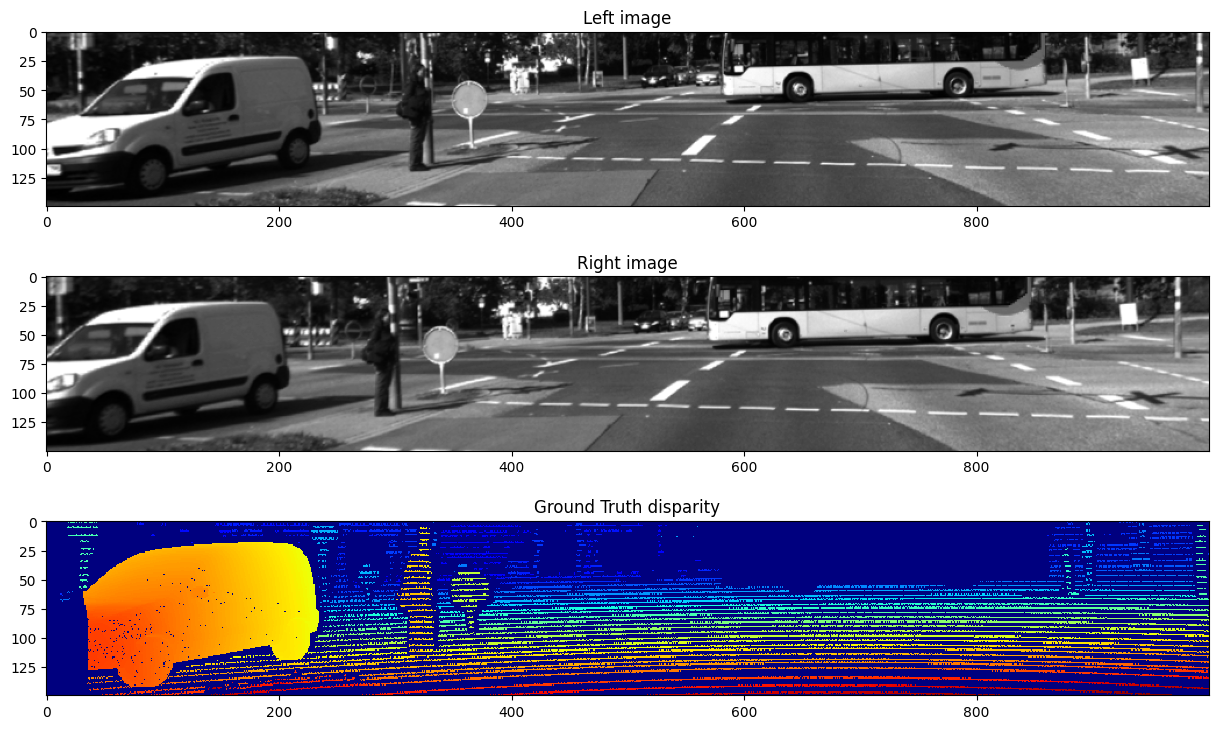

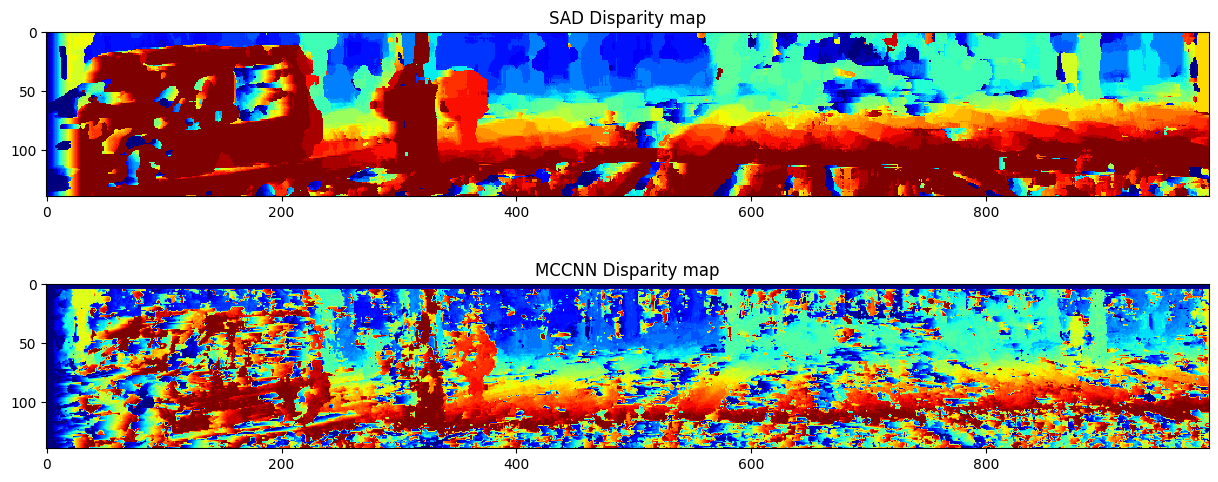

--------------------------------------------------------------------------
Metrics: 		 SAD 			 MCCNN
--------------------------------------------------------------------------
Average Error 		 18.351213 		 15.651435
%error > 1 pixel	 97.43333333333334 	 93.682
%error > 2 pixels	 95.194 	 91.71933333333332
%error > 4 pixels	 91.27866666666667 	 87.31466666666667


In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(9)
fig.set_figwidth(15)

ax1.imshow(im_left.cpu().numpy(), cmap="gray")
ax1.title.set_text('Left image')

ax2.imshow(im_right.cpu().numpy(), cmap="gray")
ax2.title.set_text('Right image')

ratio = float(im_dispnoc_full.shape[1])/disp_map.shape[1] #ratio for the actual disparity in pixel

ax3.imshow(im_dispnoc.cpu().numpy()/ratio, cmap="jet", interpolation='nearest')
ax3.title.set_text('Ground Truth disparity')
fig, (ax4, ax5) = plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(15)

ax4.imshow((disp_map.cpu().numpy()), cmap='jet', interpolation='nearest')
ax4.title.set_text('SAD Disparity map')

ax5.imshow((disp_map_cnn.cpu().numpy().astype(np.float32))*50, cmap='jet')
ax5.title.set_text('MCCNN Disparity map')

plt.show()

cnn_avgerr, cnn_bad1, cnn_bad2, cnn_bad4 = evaluate_stereo(im_dispnoc_full.cpu().numpy(),disp_map_cnn.cpu().numpy().astype(np.float32))
sad_avgerr,  sad_bad1, sad_bad2, sad_bad4 = evaluate_stereo(im_dispnoc_full.cpu().numpy(),disp_map.cpu().numpy().astype(np.float32))


print('--------------------------------------------------------------------------')
print('Metrics: \t\t', 'SAD','\t\t\t','MCCNN')
print('--------------------------------------------------------------------------')
print('Average Error \t\t',sad_avgerr,'\t\t', cnn_avgerr)
print('%error > 1 pixel\t', sad_bad1,'\t',cnn_bad1)
print('%error > 2 pixels\t',sad_bad2, '\t',cnn_bad2)
print('%error > 4 pixels\t',sad_bad4, '\t', cnn_bad4)

**Deliverables:** Make a screen shot of the disparity map and the evaluation results above and copy them to the report.

**Questions:**


1.   Qualitatively, between SAD and MCCNN, which disparity map do you think looks better? Explain your reasoning.
2.   Quantitatively, between SAD and MCCNN, which one acieve better score on the metrics? Why do you think that's the case?

